

# The "occasionally dishonest casino" HMM

We use the [dynamax](https://github.com/probml/dynamax/blob/main/dynamax/) library.



In [1]:
try:
    import probml_utils as pml
    from probml_utils import savefig, latexify
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml
    from probml_utils import savefig, latexify

In [2]:
try:
    from dynamax.hmm.demos.casino_hmm import make_model_and_data, plot_results, plot_inference
except ModuleNotFoundError:
    %pip install -qq dynamax
    from dynamax.hmm.demos.casino_hmm import make_model_and_data, plot_results, plot_inference

In [3]:
from functools import partial

import jax.numpy as jnp
import jax.random as jr
from jax import vmap

import optax

from graphviz import Digraph
import matplotlib.pyplot as plt

from dynamax.hmm.models import CategoricalHMM

In [4]:
latexify(width_scale_factor=3.2, fig_height=1.5)

/Users/scott/miniconda3/envs/dynamax/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [5]:
num_states = 2
num_emissions = 1
num_classes = 6
num_batches = 1
num_timesteps = 300
hmm = CategoricalHMM(num_states, num_emissions, num_classes)

params = dict(
    initial=dict(probs=jnp.array([1, 1]) / 2),
    transitions=dict(transition_matrix=jnp.array([[0.95, 0.05], [0.10, 0.90]])),
    emissions=dict(
        probs=jnp.array(
            [
                [1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6],  # fair die
                [1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 10, 5 / 10],  # loaded die
            ]
        ).reshape(num_states, num_emissions, num_classes)
    ),
)

batch_states, batch_emissions = vmap(partial(hmm.sample, params, num_timesteps=num_timesteps))(
    jr.split(jr.PRNGKey(0), num_batches)
)

In [6]:
posterior = hmm.smoother(params, batch_emissions[0])
most_likely_states = hmm.most_likely_states(params, batch_emissions[0])

In [7]:
def print_seq(true_states, emissions):
    T = 70
    to_string = lambda x: "".join(str(x + 1).split())
    print("hid: ", to_string(true_states[:T]))
    print("obs: ", to_string(emissions[:T, 0]))


print_seq(batch_states[0], batch_emissions[0])

hid:  [1111111111122111111111111111111111111111111111111111122222222211111111]
obs:  [6431465123564461525456511613536122412645252144423454336266666226436212]


In [8]:
# count fraction of times we see 6 in each state
obs = batch_emissions[0, :, 0] + 1
hid = batch_states[0] + 1
p0 = jnp.mean(obs[hid == 1] == 6)  # fair
p1 = jnp.mean(obs[hid == 2] == 6)  # loaded
print(jnp.array([p0, p1]))
print([1.0 / 6, 5.0 / 10])

[0.14880952 0.5227273 ]
[0.16666666666666666, 0.5]


/var/folders/03/7y894xkj7k7266681pht1hw40000gn/T/ipykernel_21823/1789374025.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/03/7y894xkj7k7266681pht1hw40000gn/T/ipykernel_21823/1789374025.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/03/7y894xkj7k7266681pht1hw40000gn/T/ipykernel_21823/1789374025.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


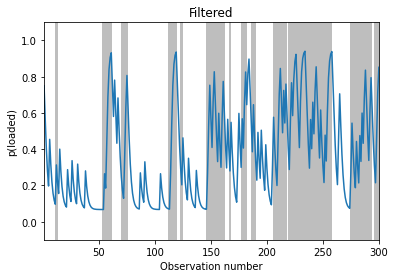

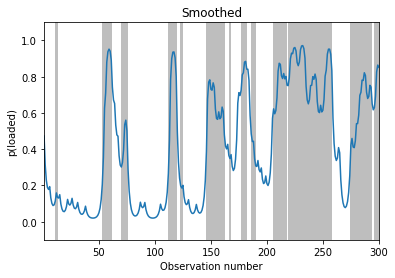

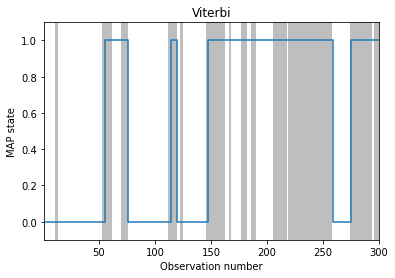

In [9]:
def plot_posteriors(true_states, emissions, posterior, most_likely_states):

    fig, ax = plt.subplots()
    plot_inference(posterior.filtered_probs, true_states, ax)
    ax.set_ylabel("p(loaded)")
    ax.set_title("Filtered")
    fig.show()
    # pml.savefig("hmm_casino_filter")

    fig, ax = plt.subplots()
    plot_inference(posterior.smoothed_probs, true_states, ax)
    ax.set_ylabel("p(loaded)")
    ax.set_title("Smoothed")
    fig.show()
    # pml.savefig("hmm_casino_smooth")

    fig, ax = plt.subplots()
    plot_inference(most_likely_states, true_states, ax, map_estimate=True)
    ax.set_ylabel("MAP state")
    ax.set_title("Viterbi")
    fig.show()
    # pml.savefig("hmm_casino_map")


plot_posteriors(batch_states[0], batch_emissions[0], posterior, most_likely_states)